In [7]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

### Load Model Data 
Checkpoint: Load cached data here

In [8]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [9]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [10]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

### Model Results for (train white, test black / asian)

In [19]:
# Prepare Model Data --> [takes 2 min.]
pca = PCA(n_components=1)

def get_x_y(df): 
    x_init = np.array([pca.fit_transform(np.transpose(data)) for data in df.sample_data.values]) # shrink to 26 values
    x = x_init.reshape(x_init.shape[0], -1)
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_test_white, y_test_white = get_x_y(test_black_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [30]:
# Reshape for LSTM Input 
reshape_input = lambda x: x.reshape((x.shape[0], 1, x.shape[1]))

x_train = reshape_input(x_train)
x_val = reshape_input(x_val)
x_test_white = reshape_input(x_test_white)
x_test_black = reshape_input(x_test_black)
x_test_asian = reshape_input(x_test_asian)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Creating an LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, 26)))  # Adjust the units as needed
model.add(Dense(23, activation='softmax'))  # Output layer with 23 classes and softmax activation

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))  # Adjust epochs and batch_size as needed

Epoch 1/30
19/19 [==============================] - 3s 37ms/step - loss: 2.7732 - accuracy: 0.2575 - val_loss: 2.3964 - val_accuracy: 0.6822
Epoch 2/30
19/19 [==============================] - 0s 5ms/step - loss: 2.2381 - accuracy: 0.6611 - val_loss: 2.0001 - val_accuracy: 0.6822
Epoch 3/30
19/19 [==============================] - 0s 5ms/step - loss: 1.8422 - accuracy: 0.6611 - val_loss: 1.6030 - val_accuracy: 0.6822
Epoch 4/30
19/19 [==============================] - 0s 5ms/step - loss: 1.5463 - accuracy: 0.6611 - val_loss: 1.4080 - val_accuracy: 0.6822
Epoch 5/30
19/19 [==============================] - 0s 5ms/step - loss: 1.3930 - accuracy: 0.6611 - val_loss: 1.2911 - val_accuracy: 0.6822
Epoch 6/30
19/19 [==============================] - 0s 4ms/step - loss: 1.3025 - accuracy: 0.6611 - val_loss: 1.2197 - val_accuracy: 0.6822
Epoch 7/30
19/19 [==============================] - 0s 5ms/step - loss: 1.2451 - accuracy: 0.6611 - val_loss: 1.1772 - val_accuracy: 0.6822
Epoch 8/30
19/19 [=

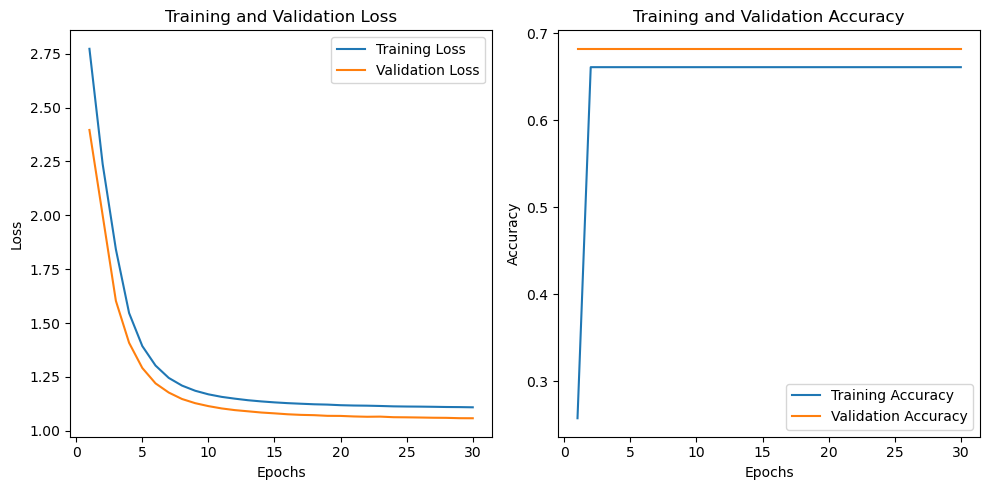

In [32]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Check Test Performance - White Patients
evaluation = model.evaluate(x_test_white, y_test_white)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on White Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 3ms/step - loss: 0.9936 - accuracy: 0.8205
Performance on White Patients
----------------------------------
Loss on test data: 0.9935532808303833
Accuracy on test data: 0.8205128312110901


In [34]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 3ms/step - loss: 0.9936 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 0.9935532808303833
Accuracy on test data: 0.8205128312110901


In [35]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 31ms/step - loss: 0.7172 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 0.717193603515625
Accuracy on test data: 0.8214285969734192
